## Different Types of Debugging

- **Coding Mistakes**: when your model does not do what you want it to do (python, pytorch, math or logic errors)
- **Training Mistakes**: when your model does what you want it to do, but is not learning well.
- **Testing/Decoding Mistakes**: when your model is learning well but outputs bad results.

## Coding Errors

**Symptoms**

- Loss does not decrease at all - obviously you need to plot the loss against epoches to show this
- Output are constants
- Training stops mid-time for unclear reasons.
- Time issue: when everything works but is too slow. In your epochs, use the time module to check the duration of all your subtasks (data loading, forward, backward,...), and find the aberrant one.

**Typical Mistakes**

- You forgot to put your model in eval mode during inference time and your model is now producing garbage.
- You passed softmax outputs to a loss that expects raw logits. E.g. passing softmax outputs to `nn.CrossEntropyLoss()`.

**Advice**

- Print everything to look for the first moment the problem appears. Be methodical.
- Check your data: Not iterating ? Instance-label misalignment ? (spend a good amount of time checking if your data is sane. This is crucial especially if you’re doing some preprocessing on your data before passing it to your network.)
- Check your shapes: everything consistent? (What does this mean?)
- Check your hyperparameters: when you print them, are they what they are supposed to be?
- Remember to turn off regularization - don't let them overwhelm your data.

## Training Errors

**Symptoms**

For those errors, usually your loss does decrease, but not enough. Or when the training errors decrease but testing/validation errors do not. Or your model learns, training and validation loss decrease, but accuracy is low.

 > If you see absurdly low performance (or even random), it is probably a coding error. A good rule of thumb to check whether it is a training or coding error is that a random classification model would have a cross-entropy loss of approximately $\log(\text{number of classes})$.

**Typical Mistakes**

- Modelization issues : your model is too small to have sufficient capacity to learn patterns (or not well designed when the problem is complex)
- Optimization issues : you cannot train your model properly
- Overfitting : your model is too big/you train too long

**Advice**

- Try a few datapoints or a random subset of the training data, and try to see if your model can overfit it, i.e. training accuracy goes to 100% and validation accuracy much less. This can assure and inform if your model has enough capacity, and also beneficial in debugging coding errors too. Note that you need to first disable regularizations and other limiting features. Once you are certain your training loss decreases to 0, you can slowly add back regularizations and increase the data size (for which you should see loss increasing) and start fine tuning.
- Check the below for optimization issues:
 > Learning rate: if too small, you will learn too slowly. If too large, you will learn for a while then diverge. Default “good” : 0.001. It is recommended to do learning rate decay : start large, then decrease (for
example when loss stops improving).

 > Optimizer: (default “good” : Adam)
 
 > Initialization: (default “good” : xavier)

 > Batching (just the batch size on simple problems). Default “good” : from 32 to 256 if you can afford it.

 > Too deep models can create optimization problems too (vanishing gradients). They can also lead to overfitting.
 
 > Look at the activation/grad distribution per layer - recall the motivation of BatchNorm: it is not good to see any strange distribution.

- Use the following tricks when you have an overfitting problem:

 > Verify that you shuffle your training data
 
 > Decrease your model size/depth
 
 > Use some of the tricks you know that help generalization : dropout, batchnorm, early stopping, validation-driven learning rate decay. Note : adaptative optimizers (Adam,...) overfit more.
 
 > It is also possible to overfit on the validation set. This happens when you try a very large amount of architectures/hyperparameters with the same validation set : you may find one that works “by chance” and won’t generalize. If you plan to look for many architectures, consider a better validation method like K-fold.
 
- In classification problem, keep an eye on the accuracy, since the loss function is usually an approximation to the (step and indifferentiable) accuracy function.

## A Simple example

We rely on the following MLP model as an example for what follows.

In [1]:
# Generating the data
import math
import numpy as np
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def sample_points(n):
    """
    :param n: Total number of data-points
    :return: A tuple (X,y) where X is a float tensor with shape (n,2)
               and y is an interger tensor with shape(n,)
    """    
    radius = np.random.random_sample(n) * 2
    angle = np.random.random_sample(n) * 2 * math.pi
    x = np.array([[r*np.cos(a), r*np.sin(a)] for (r, a) in zip(radius, angle)])
    y = radius < 1
    x = tf.convert_to_tensor(x)
    y = tf.convert_to_tensor(y)
    return x, y

X_train, y_train = sample_points(10000)
X_valid, y_valid = sample_points(2000)
X_val,y_val = sample_points(500)

print(tf.shape(X_train), tf.shape(y_train))

tf.Tensor([10000     2], shape=(2,), dtype=int32) tf.Tensor([10000], shape=(1,), dtype=int32)


In [2]:
# Build a simple MLP
def build_model(dims, activation):
    model = keras.models.Sequential()
    for i in range(len(dims)):
        if i == 0:
            model.add(keras.layers.Dense(dims[0], input_shape=(2,), activation=activation)) # Note that you need to specify the input_shape, or otherwise the model will not build!
        elif i < len(dims)-1:
            model.add(keras.layers.Dense(dims[i], activation=activation))
        else: # output layer
            model.add(keras.layers.Dense(dims[i], activation="softmax"))
    return model

# Test the function
dims = [12, 1]
model = build_model(dims, "relu")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                36        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


## `kera.callbacks` for Printout Debug 

This can be done via custom callbacks. As an example of how to do that, the following custom callback will display the ratio between the validation loss and the training loss during training (e.g., to detect overfitting):

In [3]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

As you might expect, you can implement `on_train_begin()`, `on_train_end()`, `on_epoch_begin()`, `on_epoch_end()`, `on_batch_begin()`, and `on_batch_end()`. Callbacks can also be used during evaluation and predictions, should you ever need them (e.g., for debugging). For evaluation, you should implement `on_test_begin()`, `on_test_end()`, `on_test_batch_begin()`, or `on_test_batch_end()` (called by `evaluate()`), and for prediction you should implement `on_predict_begin()`, `on_predict_end()`, `on_predict_batch_begin()`, or `on_predict_batch_end()` (called by `predict()`).

## TensorBoard for in-training Visualization

TensorBoard is a great interactive visualization tool that you can use to view the learning curves during training, compare learning curves between multiple runs, visualize the computation graph, analyze training statistics, view images generated by your model, visualize complex multidimensional data projected down to 3D and automatically clustered for you, and more! This tool is installed automatically when you install `tensorflow`.

To use it, you must modify your program so that it outputs the data you want to visualize to special binary log files called *event files*. Each binary data record is called a *summary*. The TensorBoard server will monitor the log directory, and it will automatically pick up the changes and update the visualizations: this allows you to visualize live data (with a short delay), such as the learning curves during training. In general, you want to point the TensorBoard server to a root log directory and configure your program so that it writes to a different subdirectory every time it runs. This way, the same TensorBoard server instance will allow you to visualize and compare data from multiple runs of your program, without getting everything mixed up.




In [4]:
import os
root_logdir = os.path.join(os.curdir, "tensorboard_logs")
def get_run_logdir():    
    import time    
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") # You may want to add more info to the dir name to differentiate run info, such values of the hyperparameters, etc.   
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

`keras` provides a nice `TensorBoard()` callback, which takes the function you defined.

In [5]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
train_val_ratio_cb = PrintValTrainRatioCallback()

Now we compile and fit the model. Notice how the `callbacks` defined in previous examples are speficied in `fit()`.

In [6]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.1),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, train_val_ratio_cb]) # Note how the callbacks are specified here
                                               # Look for the 'val/train' in the logs below!

Train on 10000 samples, validate on 2000 samples
Epoch 1/100
 8032/10000 [=======================>......] - ETA: 0s - loss: 7.5349 - accuracy: 0.5086
val/train: 1.05
10000/10000 [==============================] - 2s 150us/sample - loss: 7.5501 - accuracy: 0.5076 - val_loss: 7.9350 - val_accuracy: 0.4825
Epoch 2/100
 8032/10000 [=======================>......] - ETA: 0s - loss: 7.5139 - accuracy: 0.5100
val/train: 1.05
10000/10000 [==============================] - 0s 32us/sample - loss: 7.5501 - accuracy: 0.5076 - val_loss: 7.9350 - val_accuracy: 0.4825
Epoch 3/100
 8032/10000 [=======================>......] - ETA: 0s - loss: 7.5712 - accuracy: 0.5062
val/train: 1.05
10000/10000 [==============================] - 0s 30us/sample - loss: 7.5501 - accuracy: 0.5076 - val_loss: 7.9350 - val_accuracy: 0.4825
Epoch 4/100
 8128/10000 [=======================>......] - ETA: 0s - loss: 7.4799 - accuracy: 0.5122
val/train: 1.05
10000/10000 [==============================] - 0s 30us/sample - loss

Epoch 33/100
 8320/10000 [=======================>......] - ETA: 0s - loss: 7.6150 - accuracy: 0.5034
val/train: 1.05
10000/10000 [==============================] - 0s 29us/sample - loss: 7.5501 - accuracy: 0.5076 - val_loss: 7.9350 - val_accuracy: 0.4825
Epoch 34/100
 8576/10000 [========================>.....] - ETA: 0s - loss: 7.6094 - accuracy: 0.5037
val/train: 1.05
10000/10000 [==============================] - 0s 28us/sample - loss: 7.5501 - accuracy: 0.5076 - val_loss: 7.9350 - val_accuracy: 0.4825
Epoch 35/100
 8640/10000 [========================>.....] - ETA: 0s - loss: 7.5406 - accuracy: 0.5082
val/train: 1.05
10000/10000 [==============================] - 0s 28us/sample - loss: 7.5501 - accuracy: 0.5076 - val_loss: 7.9350 - val_accuracy: 0.4825
Epoch 36/100
 8384/10000 [========================>.....] - ETA: 0s - loss: 7.5203 - accuracy: 0.5095
val/train: 1.05
10000/10000 [==============================] - 0s 29us/sample - loss: 7.5501 - accuracy: 0.5076 - val_loss: 7.9350

 7904/10000 [======================>.......] - ETA: 0s - loss: 7.5502 - accuracy: 0.5076
val/train: 1.05
10000/10000 [==============================] - 0s 30us/sample - loss: 7.5501 - accuracy: 0.5076 - val_loss: 7.9350 - val_accuracy: 0.4825
Epoch 66/100
 9824/10000 [============================>.] - ETA: 0s - loss: 7.5386 - accuracy: 0.5083
val/train: 1.05
10000/10000 [==============================] - 0s 33us/sample - loss: 7.5501 - accuracy: 0.5076 - val_loss: 7.9350 - val_accuracy: 0.4825
Epoch 67/100
 9568/10000 [===========================>..] - ETA: 0s - loss: 7.5256 - accuracy: 0.5092
val/train: 1.05
10000/10000 [==============================] - 0s 43us/sample - loss: 7.5501 - accuracy: 0.5076 - val_loss: 7.9350 - val_accuracy: 0.4825
Epoch 68/100
 9600/10000 [===========================>..] - ETA: 0s - loss: 7.5772 - accuracy: 0.5058
val/train: 1.05
10000/10000 [==============================] - 1s 55us/sample - loss: 7.5501 - accuracy: 0.5076 - val_loss: 7.9350 - val_accura

If you run this code, the `TensorBoard()` callback will take care of creating the log directory for you (along with its parent directories if needed), and during training it will create event files and write summaries to them. There’s one directory per run, each containing one subdirectory for training logs and one for validation logs. Both contain event files, but the training logs also include profiling traces: this allows TensorBoard to show you exactly how much time the model spent on each part of your model, across all your devices, which is great for locating performance bottlenecks.

Next we look at how to launch the UI for `TensorBoard` in Jupyter notebook. The first line loads the TensorBoard extension, and the second line starts a TensorBoard server on port 6006 (unless it is already started) and connects to it. Once it is up, you can open a web browser and go to http://localhost:6006.

In [13]:
%reload_ext tensorboard
%tensorboard --logdir=root_logdir --port=6007

Reusing TensorBoard on port 6007 (pid 1474), started 0:44:57 ago. (Use '!kill 1474' to kill it.)

Additionally, TensorFlow offers a lower-level API in the tf.summary package. The following code creates a SummaryWriter using the create_file_writer() function, and it uses this writer as a context to log scalars, histograms, images, audio, and text, all of which can then be visualized using `TensorBoard`.

In [8]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # some random data
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # random 32×32 RGB images
        tf.summary.image("my_images", images * step / 1000, step=step)
        texts = ["The step is " + str(step), "Its square is " + str(step**2)]
        tf.summary.text("my_text", texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

## Tensorflow Model Analysis (TFMA) for after-training Model Validation

TensorFlow Model Analysis (TFMA), an open-source library that combines the power of TensorFlow and [Apache Beam](https://beam.apache.org/) to compute and visualize evaluation metrics.

Though both are inspecting model performance via visualization, TFMA has several differences from Tensorboard

- During Training vs after Training

    - TensorFlow metrics that are visualized in TensorBoard are computed during a training run and show how a metric changes against global training steps (across all training workers). This can answer questions such as “Is my model converging?”.
    - TFMA exports a SavedModel containing the eval graph and additional metadata to compute metrics, which means it computes metrics once using the exported model. It is important to evaluate performance on the final model because that’s the model that will be deployed.
    
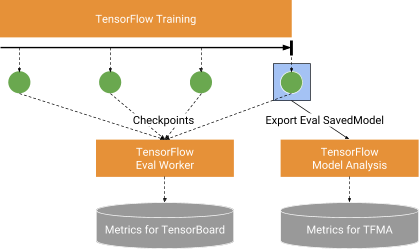

- One model vs multiple models over time
    - TensorBoard is commonly used to inspect the training progress of a single model. It can also be used to visualize metrics for more than one model, with performance for each plotted against their global training steps as they are training.
    - TFMA also allows developers to visualize model metrics over time in a time series graph. The difference between TensorBoard and TFMA lies within the horizontal axis. TensorBoard visualizes streaming metrics of multiple models over global training steps, whereas TFMA visualizes metrics computed for a single model over multiple versions of the exported SavedModel.

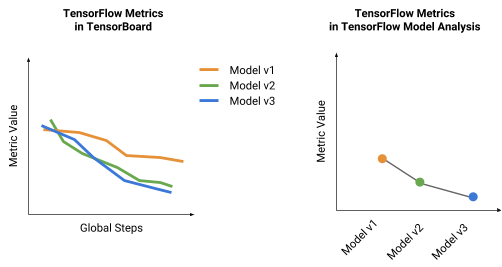

- Aggregate vs sliced metrics

    - Most model evaluation results look at aggregate metrics. A model may have an acceptable AUC over the entire eval dataset, but underperform on specific slices. In general, a model with good performance “on average” may exhibit failure modes that are not apparent by looking at an aggregate metric.
    - Slicing metrics allows us to analyze the performance of a model on a more granular level. This functionality enables developers to identify slices where examples may be mislabeled, or where the model over- or under-predicts. For example, TFMA could be used to analyze whether a model that predicts the generosity of a taxi tip works equally well for riders that take the taxi during day hours vs night hours (if sliced by the feature hour).
    
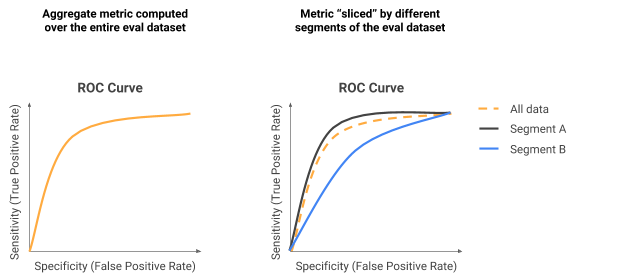

- Streaming vs full-pass metrics

    - TensorFlow metrics that are visualized in TensorBoard are commonly computed on a mini-batch basis during training. They are called “streaming metrics” and are approximations based on those observed mini-batches
    
    - TFMA uses Apache Beam to do a full pass over the specified evaluation dataset. This not only allows more accurate calculation of metrics, but also scales up to massive evaluation datasets, since Beam pipelines can be run using distributed processing back-ends. Note that TFMA computes the same TensorFlow metrics that are computed by the TensorFlow eval worker, just more accurately by doing a full pass over the specified dataset. TFMA can also be configured to compute additional metrics that were not defined in the model. Furthermore, if evaluation datasets are sliced to compute metrics for specific segments, each of those segments may only contain a small number of examples. To compute accurate metrics, a deterministic full pass over those examples is important.

One last note about TFMA is that it can be used as part of the TFX pipeline; see under 'Model Validation' in the pipeline overview graph of [TFX](MLOps_overview_and_scoping.ipynb). TFMA can also be used standalone, especially creating visualization in a jupyter notebook.

## References

- CMU Deep Learning Course Fall 2019.
- <Hands-on Machine Learning with Scikit-Learn, Keras, and Tensorflow>, 2nd Edition. Chapters 10, 11.
- [Introducing Tensorflow Model Analysis](https://blog.tensorflow.org/2018/03/introducing-tensorflow-model-analysis.html)

### Further Reading

- [Tensorflow Model Analysis Archetecture](https://www.tensorflow.org/tfx/model_analysis/architecture)